In [14]:
#! pip install imblearn
#! pip install xgboost

#from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
from sklearn.metrics import confusion_matrix
import zipfile
from zipfile import ZipFile
from pathlib import Path
from typing import Dict, Optional, List, Sequence, Tuple, Any
import pandas as pd
from pandas import DataFrame
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
#from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from docx import Document
import matplotlib.pyplot as plt
import dill as pkl  # dill is used because pickle cannot handle lambda functions
import pickle
from datetime import date
from pathlib import Path
import zipfile
from zipfile import ZipFile
import dill as pkl
import os
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline

TODAY = date.today().strftime("%Y%m%d")
CLIENT = "Uniper"
MIN_NUM_OF_SAMPLES = 5
COUNTRY = 'ALL'
SAVE_CLFS = True
RES_DIR = Path("./retraining_october21/")
SCAN_ID_COL = "filename"  # document identifier col used when reducing global df to relevant examples for attribute

In [2]:
if not os.path.exists(RES_DIR):
    os.makedirs(RES_DIR)

In [3]:
def reduce_to_relevant(df: DataFrame, col: str, min_num_samples: int) -> DataFrame:
    # find rows for values that appear at least min_num_samples times
    relevant = [x for x in df[col].value_counts().index
                if df[col].value_counts()[x] >= min_num_samples]
    # create boolean mask
    mask = [(x in relevant) for x in df[col]]
    print(
        f"Reduced to {len(df[mask])} samples from {len(relevant)} relevant classes. (N={min_num_samples})"
    )
    return df[mask]


def get_reduced_df(
        df: DataFrame,
        feature_col: str,
        scan_id_col: str,
        min_num_samples: int) -> DataFrame:
    # keep only documents with unambiguous value for this col
    df_ = df.drop_duplicates(subset=[scan_id_col, feature_col])\
            .groupby(scan_id_col)\
            .filter(lambda x: len(x) == 1)

    return reduce_to_relevant(df_, feature_col, min_num_samples)


def split_for_target_col(df, col, test_size=0.2, random_state=42):
    return train_test_split(
        df,
        df[col],
        test_size=test_size,
        random_state=random_state
    )


def split_for_target_col_stratified(df, col, test_size=0.2, random_state=42,):
    return train_test_split(df,
        df[col],
        test_size=test_size,
        random_state=random_state,
        stratify=df[col]
    )


def _get_top_n_results_with_confs(
        clazzes: Sequence[str],
        probs: List[float],
        n: int = 1) -> List[Tuple[str, float]]:
    return sorted(
        zip(clazzes, probs),
        key=lambda x: x[1],
        reverse=True
    )[:n]


def get_results_for_target(
        target_clf: Any,
        df: DataFrame) -> List[Tuple[str, float]]:
    probs = target_clf.predict_proba(df)
    clazzes = target_clf.classes_
    results = []
    for prob_list in probs:
        results.append(_get_top_n_results_with_confs(clazzes, prob_list)[0])
    return results

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
tday = date.today().strftime("%A %d. %B %Y") 
print(f"Models trained on {tday} with package versions: \n")
print(f"scikit-learn: {sklearn.__version__}")
print(f"dill: {pkl.__version__}")

Models trained on Sunday 23. January 2022 with package versions: 

scikit-learn: 0.24.2
dill: 0.3.4


In [6]:
# dict used to enrich ground truth later
country_to_country_group = {
    "DE": 'de',
    "SE": 'se',
    "AT": 'at',
    "GB": 'uk',
    "BE": 'ubx',
    "NL": 'ubx',
    "LU": 'ubx'   
}

In [7]:
df_ground_truth = pd.read_excel("C:/Users/runyaoyu/Desktop/Project1101/Sebastian/RetrainingOctober2021/Daten/Uniper_GT_09_21.xlsx") #Uniper_GT_09_21.xlsx
df_ground_truth.dropna(subset=['gl_document_scan_id'], inplace=True)
df_ground_truth["gl_document_scan_id"] = df_ground_truth["gl_document_scan_id"].apply(lambda x: x.lower())


In [8]:
with open("C:/Users/runyaoyu/Desktop/Project1101/Sebastian/RetrainingOctober2021/Daten/texts_all_rt202110.pkl", "rb") as file:
    df_lume = pickle.load(file)

df_merged = df_lume.merge(df_ground_truth, left_on=["filename"], right_on=["gl_document_scan_id"], how="inner")
df_merged["country"] = df_merged['le_country_id'].apply(lambda x: country_to_country_group[x])
df_merged["country"].value_counts()


de     47313
se     36580
ubx     4684
uk      3829
at      2429
Name: country, dtype: int64

In [9]:
df_lume = df_merged
print(df_lume.shape, "\n")

for country in ["de", "at", "uk", "se", "ubx"]:
    with open(f"C:/Users/runyaoyu/Desktop/Project1101/Sebastian/RetrainingOctober2021/Daten/ocr_text_df_{country}.pkl", 'rb') as file:  
        df_lume_country = pickle.load(file)
    df_lume_country["country"] = country
    print(f"shape {country}: {df_lume_country.shape}\n")
    df_lume = pd.concat([df_lume, df_lume_country], ignore_index=True)

(94835, 57) 

shape de: (23618, 3)

shape at: (478, 3)

shape uk: (7865, 3)

shape se: (22014, 3)

shape ubx: (4629, 3)



In [10]:
df_lume = df_lume[["filename", "text", "country", "gl_posting_id"]]
df_lume.head()

# some cleaning
df_lume["filename"] = df_lume["filename"].apply(lambda filename: filename.lower())
df_lume = df_lume[df_lume["text"] != 0]
df_lume = df_lume[df_lume["text"] != '']
df_lume["text"] = df_lume["text"].apply(lambda text: str(text).replace("\r\n", " ").replace("\n", " ").lower())
df_lume.dropna(subset=['text'], inplace=True)
df_lume.drop_duplicates(inplace=True)

In [11]:
def get_certain_class_after_vec_country(df_lume, label):
    label = label
    df_attr = get_reduced_df(df_lume, label, SCAN_ID_COL, MIN_NUM_OF_SAMPLES)
    x_train, x_test, y_train, y_test = split_for_target_col_stratified(df_attr, label)
    vectorizer = TfidfVectorizer(max_features=20000, max_df=0.75, sublinear_tf=True,)
    X_train = x_train['text']
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test = x_test['text']
    X_test_vec = vectorizer.transform(X_test)
    return x_train, x_test, y_train, y_test, X_train_vec, X_test_vec

In [12]:
# country
label = 'country'
x_train, x_test, y_train, y_test, X_train_vec, X_test_vec = get_certain_class_after_vec_country(df_lume, label)

Reduced to 89503 samples from 5 relevant classes. (N=5)


In [ ]:
def see_before_balance(y_train, y_test, y):
    f,a = plt.subplots()
    sns.histplot(y_train, label='train',ax=a,stat='count',alpha =0.7,color='orange')
    sns.histplot(y_test,label='test',ax=a,stat='count',alpha =0.7,color='purple')
    sns.histplot(y, label='full', ax=a,stat='count',alpha=0.7,color='green')
    a.set_xlabel('Class')
    a.legend()
    plt.show()


def see_after_balance(y_train, y_test, y, X_train_vec, X_test_vec):
    ros = RandomOverSampler(random_state=2)
    X_train_vec, y_train = ros.fit_resample(X_train_vec, y_train)

    f,a = plt.subplots()
    sns.histplot(y_train, label='train',ax =a,stat='count',alpha =0.7,color='orange')
    sns.histplot(y_test,label='test',ax=a,stat='count',alpha =0.7,color='green')

    a.set_xlabel('Class')
    a.legend()
    plt.show()

In [13]:
# Runyao, added parameter search
def train_statistical_model(model, X_train_vec, y_train, X_test_vec, y_test):

    model.fit(X_train_vec, y_train)
    y_train_pred = model.predict(X_train_vec)
    y_test_pred = model.predict(X_test_vec)

    print(model.best_params_)
    print(model.best_score_)
    print("Training Accuracy: {:.3f}".format(accuracy_score(y_train, y_train_pred)))
    print("Test Accuracy: {:.3f}".format(accuracy_score(y_test, y_test_pred)))

    print(classification_report(y_test, y_test_pred))

    # confusion matix
    conf_train = confusion_matrix(y_train, y_train_pred)
    conf_test = confusion_matrix(y_test, y_test_pred)

    fg, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))
    sns.heatmap(conf_train, annot=True, fmt="d", ax=ax1)
    ax1.set(xlabel="predicted label")
    ax1.set(ylabel="actual label")
    #ax1.set_xticklabels(['0','1'])
    #ax1.set_yticklabels(['0','1'])
    ax1.set(title="Confusion Matrix for training set")

    sns.heatmap(conf_test, annot=True, fmt="d", ax=ax2)
    ax2.set(xlabel="predicted label")
    ax2.set(ylabel="actual label")
    #ax2.set_xticklabels(['0','1'])
    #ax2.set_yticklabels(['0','1'])
    ax2.set(title="Confusion Matrix for test set")

Fitting 10 folds for each of 45 candidates, totalling 450 fits


C:\Users\runyaoyu\anacondaaa\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.99935755 0.99930169        nan 0.99931566 0.99935756 0.99810062
 0.99810062 0.99762576 0.99810062 0.99814251        nan        nan
        nan        nan        nan 0.99935755 0.99930169        nan
 0.99927376 0.99930169 0.99808665 0.99808665 0.9975699  0.99808665
 0.99810062        nan        nan        nan        nan        nan
 0.99935755 0.99930169        nan 0.99930169 0.99927376 0.99807268
 0.99807268 0.99750007 0.99807268 0.99807268        nan        nan
        nan        nan        nan]
  warnings.warn(
C:\Users\runyaoyu\anacondaaa\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


{'C': 1, 'penalty': 'none', 'solver': 'saga'}
0.9993575555519151
Training Accuracy: 1.000
Test Accuracy: 0.999
              precision    recall  f1-score   support

          at       1.00      1.00      1.00       153
          de       1.00      1.00      1.00      7726
          se       1.00      1.00      1.00      7005
         ubx       1.00      1.00      1.00      1309
          uk       1.00      1.00      1.00      1708

    accuracy                           1.00     17901
   macro avg       1.00      1.00      1.00     17901
weighted avg       1.00      1.00      1.00     17901



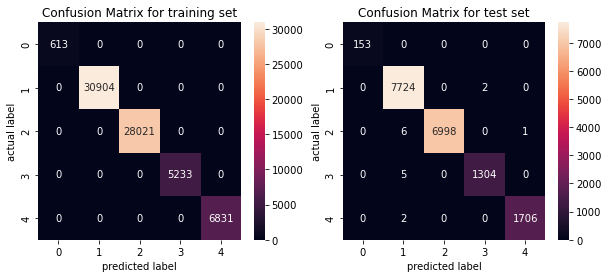

In [16]:
# Runyao, added parameter search
lr = LogisticRegression()
parameters = {'penalty': ['none', 'l2', 'elasticnet'], 'C':[1, 0.95, 0.9], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
model = GridSearchCV(lr, parameters, n_jobs=-1, verbose=1, scoring='accuracy', cv=10)
#model.get_params().keys()
train_statistical_model(model, X_train_vec, y_train, X_test_vec, y_test)

In [17]:
df_lume['gl_posting_id'].value_counts(dropna=False)

40.0    61677
NaN     58383
50.0     5581
70.0        5
91.0        4
80.0        1
Name: gl_posting_id, dtype: int64

In [18]:
df_lume.dropna(subset=['gl_posting_id'], inplace=True)
df_lume["gl_posting_id"] = df_lume["gl_posting_id"].apply(lambda x: int(x))

In [19]:
def get_certain_class_after_vec_gl_posting(df_lume, label):
    label = label
    df_attr = get_reduced_df(df_lume, label, SCAN_ID_COL, min_num_samples=6)
    x_train, x_test, y_train, y_test = split_for_target_col_stratified(df_attr, label)
    vectorizer = TfidfVectorizer(max_features=20000, max_df=0.75, sublinear_tf=True,)
    X_train = x_train['text']
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test = x_test['text']
    X_test_vec = vectorizer.transform(X_test)
    return x_train, x_test, y_train, y_test, X_train_vec, X_test_vec

In [20]:
label = 'gl_posting_id'
x_train, x_test, y_train, y_test, X_train_vec, X_test_vec = get_certain_class_after_vec_gl_posting(df_lume, label)

Reduced to 62601 samples from 2 relevant classes. (N=6)


Fitting 10 folds for each of 45 candidates, totalling 450 fits


C:\Users\runyaoyu\anacondaaa\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.98759984 0.98823882        nan 0.98973642 0.98979633 0.97140575
 0.97140575 0.97144569 0.97140575 0.97144569        nan        nan
        nan        nan        nan 0.98759984 0.98823882        nan
 0.98971645 0.98975639 0.97072684 0.97072684 0.97072684 0.97072684
 0.97074681        nan        nan        nan        nan        nan
 0.98759984 0.98823882        nan 0.98971645 0.98973642 0.97020767
 0.97022764 0.97020767 0.97022764 0.97020767        nan        nan
        nan        nan        nan]
  warnings.warn(
C:\Users\runyaoyu\anacondaaa\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


{'C': 1, 'penalty': 'none', 'solver': 'saga'}
0.9897963258785942
Training Accuracy: 1.000
Test Accuracy: 0.989
              precision    recall  f1-score   support

          40       0.99      1.00      0.99     11829
          50       0.95      0.85      0.90       692

    accuracy                           0.99     12521
   macro avg       0.97      0.92      0.95     12521
weighted avg       0.99      0.99      0.99     12521



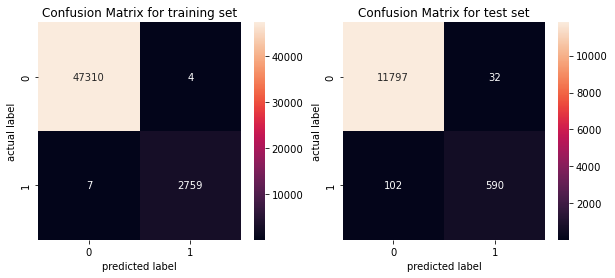

In [21]:
# Runyao, added parameter search
lr = LogisticRegression()
parameters = {'penalty': ['none', 'l2', 'elasticnet'], 'C':[1, 0.95, 0.9], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
model = GridSearchCV(lr, parameters, n_jobs=-1, verbose=1, scoring='accuracy', cv=10)
#model.get_params().keys()
train_statistical_model(model, X_train_vec, y_train, X_test_vec, y_test)